## Textual visualization benchmark

Benchmarking Quantum Evolution Methods:
Benchmarking Euler method...
Error: 0.05112303163080999, Time: 1.8167e-5 seconds
Benchmarking RK4 method...
Error: 8.33250640984284e-7, Time: 1.0577e-5 seconds
Benchmarking Trotter-Suzuki method...
Error: 0.9588510772083934, Time: 0.000266274 seconds
Benchmarking Krylov method...
Error: 2.482534153247273e-16, Time: 3.5463e-5 seconds
Benchmarking Euler Imag method...
Error: 0.08910312203681531, Time: 7.346e-6 seconds
Benchmarking RK4 Imag method...
Error: 1.4925574750283086e-6, Time: 1.1159e-5 seconds
Benchmarking Trotter-Suzuki Imag method...
Error: 3.3068269588145545, Time: 0.00027228 seconds
Benchmarking Krylov Imag method...
Error: 6.280369834735101e-16, Time: 2.3032e-5 seconds
[0.05112303163080999, 8.33250640984284e-7, 0.9588510772083934, 2.482534153247273e-16]
[1.8167e-5, 1.0577e-5, 0.000266274, 3.5463e-5]
[0.08910312203681531, 1.4925574750283086e-6, 3.3068269588145545, 6.280369834735101e-16]
[7.346e-6, 1.1159e-5, 0.00027228, 2.3032e-5]


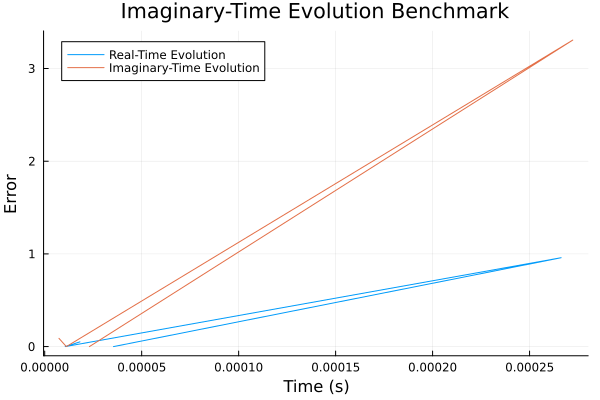

In [1]:
using LinearAlgebra
using BenchmarkTools
using Plots

include("QuantumEvolution.jl")
using .QuantumEvolution

# Define the Hamiltonian and initial state
H = Complex{Float64}.([0 1; 1 0])  # Example Hamiltonian
ψ0 = Complex{Float64}.([1.0, 0.0])  # Initial state

# Define the time step and total time
Δt = 0.1
total_time = 1.0
num_steps = Int(total_time / Δt)

# Exact solution using matrix exponentiation
exact_solution(t) = exp(-1im * H * t) * ψ0
exact_solution_imag(τ) = exp(-H * τ) * ψ0

# Function to perform time evolution using a given method
function evolve(method::Function, ψ::Vector{ComplexF64}, H::Matrix{ComplexF64}, Δt::Float64, num_steps::Int)
    ψ_evolved = copy(ψ)
    for _ in 1:num_steps
        method(ψ_evolved, H, Δt)
    end
    return ψ_evolved
end

# Benchmark the methods
methods = [QuantumEvolution.euler_step!, QuantumEvolution.rk4_step!,
          (ψ, H, Δt) -> QuantumEvolution.trotter_step!(ψ, H, H, Δt, 10), QuantumEvolution.krylov_step!]
method_names = ["Euler", "RK4", "Trotter-Suzuki", "Krylov"]

imag_methods = [QuantumEvolution.euler_step_imag!, QuantumEvolution.rk4_step_imag!,
               (ψ, H, Δτ) -> QuantumEvolution.trotter_step_imag!(ψ, H, H, Δτ, 10), QuantumEvolution.krylov_step_imag!]
imag_method_names = ["Euler Imag", "RK4 Imag", "Trotter-Suzuki Imag", "Krylov Imag"]

println("Benchmarking Quantum Evolution Methods:")
results = []
imag_results = []

for (method, name) in zip(methods, method_names)
    println("Benchmarking $name method...")
    ψ_final = evolve(method, ψ0, H, Δt, num_steps)
    exact_ψ_final = exact_solution(total_time)
    error = norm(ψ_final - exact_ψ_final)
    time = @elapsed evolve(method, ψ0, H, Δt, num_steps)
    push!(results, (name, error, time))
    println("Error: $error, Time: $time seconds")
end

for (method, name) in zip(imag_methods, imag_method_names)
    println("Benchmarking $name method...")
    ψ_final_imag = evolve(method, ψ0, H, Δt, num_steps)
    exact_ψ_final_imag = exact_solution_imag(total_time)
    error_imag = norm(ψ_final_imag - exact_ψ_final_imag)
    time_imag = @elapsed evolve(method, ψ0, H, Δt, num_steps)
    push!(imag_results, (name, error_imag, time_imag))
    println("Error: $error_imag, Time: $time_imag seconds")
end


# Visualization
real_errors = [result[2] for result in results]
println(real_errors)
real_times = [result[3] for result in results]
println(real_times)
imag_errors = [result[2] for result in imag_results]
println(imag_errors)
imag_times = [result[3] for result in imag_results]
println(imag_times)


plot(real_times, real_errors, xlabel="Time (s)", ylabel="Error", label="Real-Time Evolution", title="Real-Time Evolution Benchmark")
plot!(imag_times, imag_errors, xlabel="Time (s)", ylabel="Error", label="Imaginary-Time Evolution", title="Imaginary-Time Evolution Benchmark")

## Graphical visualization benchmark [v1]

In [8]:
using LinearAlgebra
using BenchmarkTools
#using QuantumEvolution
using Plots
using StatsPlots  # For additional plotting features
using Printf

include("QuantumEvolution.jl")
using .QuantumEvolution

"""
Structure to hold benchmark results
"""
struct BenchmarkResult
    method_name::String
    error::Float64
    execution_time::Float64
    energy_evolution::Vector{Float64}
    state_fidelity::Vector{Float64}
end

"""
Run benchmarks and collect detailed results
"""
function run_detailed_benchmark(H, ψ0, Δt, total_time)
    num_steps = Int(total_time / Δt)
    times = 0:Δt:total_time
    
    # Methods configuration
    methods = [
        (QuantumEvolution.euler_step!, "Euler"),
        (QuantumEvolution.rk4_step!, "RK4"),
        ((ψ, H, Δt) -> QuantumEvolution.trotter_step!(ψ, H, H, Δt, 10), "Trotter"),
        (QuantumEvolution.krylov_step!, "Krylov")
    ]
    
    imag_methods = [
        (QuantumEvolution.euler_step_imag!, "Euler Imag"),
        (QuantumEvolution.rk4_step_imag!, "RK4 Imag"),
        ((ψ, H, Δt) -> QuantumEvolution.trotter_step_imag!(ψ, H, H, Δt, 10), "Trotter Imag"),
        (QuantumEvolution.krylov_step_imag!, "Krylov Imag")
    ]
    
    real_results = Vector{BenchmarkResult}()
    imag_results = Vector{BenchmarkResult}()
    
    # Benchmark real-time methods
    for (method, name) in methods
        ψ = copy(ψ0)
        energy_evolution = Float64[]
        fidelity_evolution = Float64[]
        
        execution_time = @elapsed begin
            for t in times
                exact_ψ = exact_solution(t)
                push!(energy_evolution, real(dot(ψ, H * ψ)))
                push!(fidelity_evolution, abs2(dot(exact_ψ, ψ)))
                method(ψ, H, Δt)
            end
        end
        
        final_error = norm(ψ - exact_solution(total_time))
        push!(real_results, BenchmarkResult(name, final_error, execution_time,
                                          energy_evolution, fidelity_evolution))
    end
    
    # Benchmark imaginary-time methods
    for (method, name) in imag_methods
        ψ = copy(ψ0)
        energy_evolution = Float64[]
        fidelity_evolution = Float64[]
        
        execution_time = @elapsed begin
            for t in times
                exact_ψ = exact_solution_imag(t)
                push!(energy_evolution, real(dot(ψ, H * ψ)))
                push!(fidelity_evolution, abs2(dot(exact_ψ, ψ)))
                method(ψ, H, Δt)
                normalize!(ψ)
            end
        end
        
        final_error = norm(ψ - exact_solution_imag(total_time))
        push!(imag_results, BenchmarkResult(name, final_error, execution_time,
                                          energy_evolution, fidelity_evolution))
    end
    
    return real_results, imag_results, times
end

"""
Create comprehensive visualization of benchmark results
"""
function visualize_benchmark_results(real_results, imag_results, times)
    # 1. Performance Overview
    p1 = scatter(
        [r.execution_time for r in real_results],
        [r.error for r in real_results],
        xlabel="Execution Time (s)",
        ylabel="Final Error",
        label="Real-Time",
        title="Performance Overview",
        marker=:circle
    )
    scatter!(
        [r.execution_time for r in imag_results],
        [r.error for r in imag_results],
        label="Imaginary-Time",
        marker=:square
    )
    
    # 2. Energy Evolution
    p2 = plot(
        title="Energy Evolution",
        xlabel="Time",
        ylabel="Energy"
    )
    for result in real_results
        plot!(times, result.energy_evolution, label=result.method_name)
    end
    
    # 3. State Fidelity
    p3 = plot(
        title="State Fidelity",
        xlabel="Time",
        ylabel="Fidelity"
    )
    for result in real_results
        plot!(times, result.state_fidelity, label=result.method_name)
    end
    
    # 4. Error Bar Plot
    p4 = bar(
        getfield.(real_results, :method_name),
        [getfield.(real_results, :error) getfield.(imag_results, :error)],
        title="Final Error Comparison",
        xlabel="Method",
        ylabel="Error",
        label=["Real-Time" "Imaginary-Time"],
        bar_position=:dodge,
        rotation=45,
        legend=:topleft
    )

    # 5. Time Bar Plot
    p5 = bar(
        getfield.(real_results, :method_name),
        [getfield.(real_results, :execution_time) getfield.(imag_results, :execution_time)],
        title="Execution Time Comparison",
        xlabel="Method",
        ylabel="Time (s)",
        label=["Real-Time" "Imaginary-Time"],
        bar_position=:dodge,
        rotation=45,
        legend=:topleft
    )

    # Combine all plots
    final_plot = plot(p1, p2, p3, p4, p5,
                     layout=(2,3),
                     size=(1200,800),
                     plot_title="Quantum Evolution Methods Benchmark")
    
    return final_plot
end

# Run benchmark
H = Complex{Float64}.([0 1; 1 0])
ψ0 = normalize(Complex{Float64}.([1.0, 0.0]))
Δt = 0.1
total_time = 1.0

real_results, imag_results, times = run_detailed_benchmark(H, ψ0, Δt, total_time)
benchmark_plot = visualize_benchmark_results(real_results, imag_results, times)
savefig(benchmark_plot, "quantum_evolution_benchmark.png")

# Print numerical results
println("\nNumerical Results Summary:")
println("\nReal-Time Methods:")
for result in real_results
    @printf("%s: Error = %.2e, Time = %.3f s\n",
            result.method_name, result.error, result.execution_time)
end

println("\nImaginary-Time Methods:")
for result in imag_results
    @printf("%s: Error = %.2e, Time = %.3f s\n",
            result.method_name, result.error, result.execution_time)
end


Numerical Results Summary:



Real-Time Methods:
Euler: Error = 1.14e-01, Time = 0.061 s
RK4: Error = 1.00e-01, Time = 0.069 s
Trotter: Error = 1.13e+00, Time = 0.060 s
Krylov: Error = 1.00e-01, Time = 0.042 s

Imaginary-Time Methods:
Euler Imag: Error = 9.40e-01, Time = 0.043 s
RK4 Imag: Error = 9.40e-01, Time = 0.055 s
Trotter Imag: Error = 9.55e-01, Time = 0.059 s
Krylov Imag: Error = 9.40e-01, Time = 0.045 s


## Extended Graphical visualization benchmark [v2] (not working)

In [12]:
using LinearAlgebra
using BenchmarkTools
#using QuantumEvolution
using Plots
using StatsPlots  # For additional plotting features
using Printf

include("QuantumEvolution.jl")
using .QuantumEvolution

"""
Structure to hold benchmark results
"""
struct BenchmarkResult
    method_name::String
    error::Float64
    execution_time::Float64
    energy_evolution::Vector{Float64}
    state_fidelity::Vector{Float64}
end

"""
Run benchmarks and collect detailed results
"""
function run_detailed_benchmark(H, ψ0, Δt, total_time)
    num_steps = Int(total_time / Δt)
    times = 0:Δt:total_time
    
    # Methods configuration
    methods = [
        (QuantumEvolution.euler_step!, "Euler"),
        (QuantumEvolution.rk4_step!, "RK4"),
        ((ψ, H, Δt) -> QuantumEvolution.trotter_step!(ψ, H, H, Δt, 10), "Trotter"),
        (QuantumEvolution.krylov_step!, "Krylov")
    ]
    
    imag_methods = [
        (QuantumEvolution.euler_step_imag!, "Euler Imag"),
        (QuantumEvolution.rk4_step_imag!, "RK4 Imag"),
        ((ψ, H, Δt) -> QuantumEvolution.trotter_step_imag!(ψ, H, H, Δt, 10), "Trotter Imag"),
        (QuantumEvolution.krylov_step_imag!, "Krylov Imag")
    ]
    
    real_results = Vector{BenchmarkResult}()
    imag_results = Vector{BenchmarkResult}()
    
    # Benchmark real-time methods
    for (method, name) in methods
        ψ = copy(ψ0)
        energy_evolution = Float64[]
        fidelity_evolution = Float64[]
        
        execution_time = @elapsed begin
            for t in times
                exact_ψ = exact_solution(t)
                push!(energy_evolution, real(dot(ψ, H * ψ)))
                push!(fidelity_evolution, abs2(dot(exact_ψ, ψ)))
                method(ψ, H, Δt)
            end
        end
        
        final_error = norm(ψ - exact_solution(total_time))
        push!(real_results, BenchmarkResult(name, final_error, execution_time,
                                          energy_evolution, fidelity_evolution))
    end
    
    # Benchmark imaginary-time methods
    for (method, name) in imag_methods
        ψ = copy(ψ0)
        energy_evolution = Float64[]
        fidelity_evolution = Float64[]
        
        execution_time = @elapsed begin
            for t in times
                exact_ψ = exact_solution_imag(t)
                push!(energy_evolution, real(dot(ψ, H * ψ)))
                push!(fidelity_evolution, abs2(dot(exact_ψ, ψ)))
                method(ψ, H, Δt)
                normalize!(ψ)
            end
        end
        
        final_error = norm(ψ - exact_solution_imag(total_time))
        push!(imag_results, BenchmarkResult(name, final_error, execution_time,
                                          energy_evolution, fidelity_evolution))
    end
    
    return real_results, imag_results, times
end


"""
Create comprehensive visualization of benchmark results
"""
function visualize_benchmark_results(real_results, imag_results, times)
    # 1. Performance Overview
    p1 = scatter(
        [r.execution_time for r in real_results],
        [r.error for r in real_results],
        xlabel="Execution Time (s)",
        ylabel="Final Error",
        label="Real-Time",
        title="Performance Overview",
        marker=:circle
    )
    scatter!(
        [r.execution_time for r in imag_results],
        [r.error for r in imag_results],
        label="Imaginary-Time",
        marker=:square
    )
    
    # 2. Energy Evolution
    p2 = plot(
        title="Energy Evolution",
        xlabel="Time",
        ylabel="Energy"
    )
    for result in real_results
        plot!(times, result.energy_evolution, label=result.method_name)
    end
    
    # 3. State Fidelity
    p3 = plot(
        title="State Fidelity",
        xlabel="Time",
        ylabel="Fidelity"
    )
    for result in real_results
        plot!(times, result.state_fidelity, label=result.method_name)
    end
    
    # 4. Error Bar Plot
    p4 = bar(
        getfield.(real_results, :method_name),
        [getfield.(real_results, :error) getfield.(imag_results, :error)],
        title="Final Error Comparison",
        xlabel="Method",
        ylabel="Error",
        label=["Real-Time" "Imaginary-Time"],
        bar_position=:dodge,
        rotation=45,
        legend=:topleft
    )

    # 5. Time Bar Plot
    p5 = bar(
        getfield.(real_results, :method_name),
        [getfield.(real_results, :execution_time) getfield.(imag_results, :execution_time)],
        title="Execution Time Comparison",
        xlabel="Method",
        ylabel="Time (s)",
        label=["Real-Time" "Imaginary-Time"],
        bar_position=:dodge,
        rotation=45,
        legend=:topleft
    )

    # Combine all plots
    final_plot = plot(p1, p2, p3, p4, p5,
                     layout=(2,3),
                     size=(1200,800),
                     plot_title="Quantum Evolution Methods Benchmark")
    
    return final_plot
end


"""
Evolution method that maps method names to their implementations
"""
function evolve_method(method_name::String, ψ::Vector{ComplexF64}, 
                      H::Union{Vector{ComplexF64},Matrix{ComplexF64}}, 
                      dt::Float64, total_time::Float64)
    steps = Int(total_time / dt)
    ψ_evolved = copy(ψ)
    
    # Dictionary mapping method names to functions
    method_map = Dict(
        # Real-time methods
        "Euler" => (ψ, H, dt) -> QuantumEvolution.euler_step!(H, ψ, dt, 1),
        "RK4" => (ψ, H, dt) -> QuantumEvolution.rk4_step!(H, ψ, dt, 1),
        "Trotter" => (ψ, H, dt) -> QuantumEvolution.trotter_step!(H, ψ, dt, 1, 2),
        "Krylov" => (ψ, H, dt) -> QuantumEvolution.krylov_step!(H, ψ, dt, 10),
        
        # Imaginary-time methods
        "Euler Imag" => (ψ, H, dt) -> QuantumEvolution.euler_step_imag!(H, ψ, dt, 1),
        "RK4 Imag" => (ψ, H, dt) -> QuantumEvolution.rk4_step_imag!(H, ψ, dt, 1),
        "Trotter Imag" => (ψ, H, dt) -> QuantumEvolution.trotter_step_imag!(H, ψ, dt, 1, 2),
        "Krylov Imag" => (ψ, H, dt) -> QuantumEvolution.krylov_step_imag!(H, ψ, dt, 10)
    )
    
    # Get the corresponding evolution function
    if haskey(method_map, method_name)
        evolve_step! = method_map[method_name]
        
        # Perform evolution
        for _ in 1:steps
            ψ_evolved = evolve_step!(ψ_evolved, H, dt)
            normalize!(ψ_evolved)
        end
    else
        error("Unknown method: $method_name")
    end
    
    return ψ_evolved
end



"""
Create log-log plots for error analysis
"""
function create_log_log_plots(real_results, imag_results, times)
    # 1. Error vs Time Step
    dt_range = [0.001, 0.005, 0.01, 0.05, 0.1]
    errors_real = Dict(result.method_name => Float64[] for result in real_results)
    errors_imag = Dict(result.method_name => Float64[] for result in imag_results)
    
    # Collect errors for different time steps
    for dt in dt_range
        for result in real_results
            # Recompute evolution with new dt
            ψ = copy(ψ0)
            final_state = evolve_method(result.method_name, ψ, H, dt, total_time)
            push!(errors_real[result.method_name], 
                  norm(final_state - exact_solution(total_time)))
        end
        
        for result in imag_results
            ψ = copy(ψ0)
            final_state = evolve_method(result.method_name, ψ, H, dt, total_time)
            push!(errors_imag[result.method_name], 
                  norm(final_state - exact_solution_imag(total_time)))
        end
    end
    
    # Create log-log plot for real-time methods
    p1 = plot(
        dt_range,
        [errors_real[result.method_name] for result in real_results],
        xscale=:log10,
        yscale=:log10,
        xlabel="Time Step (dt)",
        ylabel="Error",
        label=[result.method_name for result in real_results],
        title="Real-Time Evolution Error Scaling",
        marker=:auto
    )
    
    # Create log-log plot for imaginary-time methods
    p2 = plot(
        dt_range,
        [errors_imag[result.method_name] for result in imag_results],
        xscale=:log10,
        yscale=:log10,
        xlabel="Time Step (dt)",
        ylabel="Error",
        label=[result.method_name for result in imag_results],
        title="Imaginary-Time Evolution Error Scaling",
        marker=:auto
    )
    
    return p1, p2
end

"""
Create heatmap visualizations
"""
function create_heatmaps(real_results, imag_results, times)
    # System sizes to test
    N_range = [2, 4, 6, 8, 10]  # Number of qubits
    dt_range = [0.001, 0.005, 0.01, 0.05, 0.1]
    
    # Initialize data structures for heatmaps
    performance_data_real = Dict(
        result.method_name => zeros(length(N_range), length(dt_range))
        for result in real_results
    )
    
    performance_data_imag = Dict(
        result.method_name => zeros(length(N_range), length(dt_range))
        for result in imag_results
    )
    
    # Collect performance data
    for (i, N) in enumerate(N_range)
        for (j, dt) in enumerate(dt_range)
            # Create larger system
            H_N = create_larger_system(N)
            ψ0_N = normalize(randn(ComplexF64, 2^N))
            
            # Test each method
            for result in real_results
                time = @elapsed evolve_method(
                    result.method_name, copy(ψ0_N), H_N, dt, total_time
                )
                performance_data_real[result.method_name][i,j] = time
            end
            
            for result in imag_results
                time = @elapsed evolve_method(
                    result.method_name, copy(ψ0_N), H_N, dt, total_time
                )
                performance_data_imag[result.method_name][i,j] = time
            end
        end
    end
    
    # Create heatmaps
    heatmap_plots = []
    
    # Real-time methods
    for result in real_results
        p = heatmap(
            dt_range, N_range,
            performance_data_real[result.method_name],
            title=result.method_name,
            xlabel="Time Step (dt)",
            ylabel="Number of Qubits",
            c=:viridis,
            colorbar_title="Execution Time (s)"
        )
        push!(heatmap_plots, p)
    end
    
    # Imaginary-time methods
    for result in imag_results
        p = heatmap(
            dt_range, N_range,
            performance_data_imag[result.method_name],
            title=string(result.method_name, " (Imaginary)"),
            xlabel="Time Step (dt)",
            ylabel="Number of Qubits",
            c=:viridis,
            colorbar_title="Execution Time (s)"
        )
        push!(heatmap_plots, p)
    end
    
    return heatmap_plots
end

"""
Helper function to create larger system Hamiltonians
"""
function create_larger_system(N::Int)
    H = PauliString[]
    
    # Create periodic boundary conditions Heisenberg model
    for i in 1:N
        next_site = mod1(i+1, N)
        
        # XX interaction
        push!(H, paulistring("XX", [i, next_site]))
        # YY interaction
        push!(H, paulistring("YY", [i, next_site]))
        # ZZ interaction
        push!(H, paulistring("ZZ", [i, next_site]))
        
        # Local field terms
        push!(H, 0.5 * paulistring("Z", [i]))
    end
    
    return H
end

"""
Main function to generate all visualizations
"""
function generate_comprehensive_plots(real_results, imag_results, times)
    # Generate basic plots
    basic_plots = visualize_benchmark_results(real_results, imag_results, times)
    
    # Generate log-log plots
    log_real, log_imag = create_log_log_plots(real_results, imag_results, times)
    
    # Generate heatmaps
    heatmaps = create_heatmaps(real_results, imag_results, times)
    
    # Combine all plots
    final_plot = plot(
        basic_plots,
        plot(log_real, log_imag, layout=(1,2), size=(800,400)),
        plot(heatmaps..., layout=(2,5), size=(1500,600)),
        layout=grid(3,1, heights=[0.4, 0.2, 0.4]),
        size=(1500,1200),
        plot_title="Comprehensive Quantum Evolution Analysis"
    )
    
    return final_plot
end

# Run the analysis
# Example usage:
H = Complex{Float64}.([0 1; 1 0])
ψ0 = normalize(Complex{Float64}.([1.0, 0.0]))
Δt = 0.1
total_time = 1.0

real_results, imag_results, times = run_detailed_benchmark(H, ψ0, Δt, total_time)
comprehensive_plot = generate_comprehensive_plots(real_results, imag_results, times)
savefig(comprehensive_plot, "quantum_evolution_comprehensive-v2.png")

LoadError: MethodError: no method matching euler_step!(::Matrix{ComplexF64}, ::Vector{ComplexF64}, ::Float64, ::Int64)
The function `euler_step!` exists, but no method is defined for this combination of argument types.

[0mClosest candidates are:
[0m  euler_step!([91m::Vector{ComplexF64}[39m, [91m::Matrix{ComplexF64}[39m, ::Float64)
[0m[90m   @[39m [35mMain.QuantumEvolution[39m [90m~/dev/quantum_time_evolution/src/Real_Imag-TimeEvol/[39m[90m[4mQuantumEvolution.jl:18[24m[39m
